In [1]:
import numpy as np

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable, default_shape_from_params

import sys

sys.path.insert(0, "/Users/larryshamalama/Documents/GitHub/pymc")

import pymc as pm

from pymc.distributions.continuous import assert_negative_support, UnitContinuous
from pymc.distributions.dist_math import betaln, bound, normal_lcdf
from pymc.distributions.distribution import Continuous

from pymc.distributions import transforms

from pymc.aesaraf import floatX, intX

# a bunch of imports for testing and printing

from aesara.tensor.basic import get_vector_length
from aesara.tensor.random.utils import params_broadcast_shapes
from aesara.tensor.shape import shape_tuple

import aesara

import matplotlib.pyplot as plt
import scipy.stats as st

%config InlineBackend.figure_format = "retina"
%matplotlib inline

print(f"pymc version: {pm.__version__}")
print(f"Aesara version: {aesara.__version__}")
print(f"pymc location: {pm.__file__}")

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


pymc version: 4.0.0
Aesara version: 2.2.1
pymc location: /Users/larryshamalama/Documents/GitHub/pymc/pymc/__init__.py


In [2]:
M = 3; K = 19

In [3]:
def stick_glueing(weights):
    shape = tuple(weights.shape or ())
    
    denominator = np.cumsum(
        np.concatenate(
            [
                np.ones(shape=shape[:-1] + (1,)),
                - weights,
            ],
            axis=-1,
        ),
        axis=-1,
    )
    
    output = (weights/(denominator[..., :-1]))
    
    return output[..., :-1]

## `GeneralizedDirichlet`

In [4]:
class GeneralizedDirichletRV(RandomVariable):
    pass

with pm.Model() as model:
    d = pm.Dirichlet(name="dirichlet-test", a=np.array([[1, 2, 3], [4, 5, 6]]))
    
    sample = pm.sample(1000, chains=1)
    
sample.to_dict()["posterior"]["dirichlet-test"][0].mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [dirichlet-test]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


array([[0.16072921, 0.34188192, 0.49738887],
       [0.27031162, 0.32281661, 0.40687177]])

## `StickBreakingWeightsRV`

In [5]:
class StickBreakingWeightsRV(RandomVariable):
    name = "stick_breaking_weights"
    ndim_supp = 1
    ndims_params = [0]
    dtype = "floatX"
    _print_name = ("StickBreakingWeights", "\\operatorname{StickBreakingWeights}")
    
    def __call__(self, alpha=1., size=None, **kwargs):
        return super().__call__(alpha, size=size, **kwargs)

    def _infer_shape(self, size, dist_params, param_shapes=None):
        return size
    
    @classmethod
    def rng_fn(cls, rng, alpha, size):
        if size is None:
            raise ValueError("size cannot be None")  
        elif isinstance(size, int):
            size = (size,)
        else:
            size = tuple(size)
        
        if np.ndim(alpha) == 0:
            betas = rng.beta(1, alpha, size=size)
        else:
            betas = np.empty(alpha.size + size)

            for idx in np.ndindex(size):
                betas[idx] = rng.beta(1, alpha[idx], size=size)
        
        sticks = np.concatenate(
            (
                np.ones(shape=(size[:-1] + (1,))),
                np.cumprod(1 - betas[..., :-1], axis=-1),
            ),
            axis=-1,
        )
        
        weights = sticks * betas
        weights = np.concatenate(
            (
                weights,
                1 - weights.sum(axis=-1)[..., np.newaxis]
            ),
            axis=-1,
        )

        return weights
    

stickbreakingweights = StickBreakingWeightsRV()

In [6]:
# all test points working
_ = stickbreakingweights(alpha=M, size=7).eval()
_ = stickbreakingweights(alpha=M, size=[100, 7]).eval()
_ = stickbreakingweights(alpha=M, size=[10, 11, 7]).eval()

_ = stickbreakingweights(alpha=np.array([[1, 2], [4, 5]]), size=[10, 11, 7])

## Testing `rng_fn`

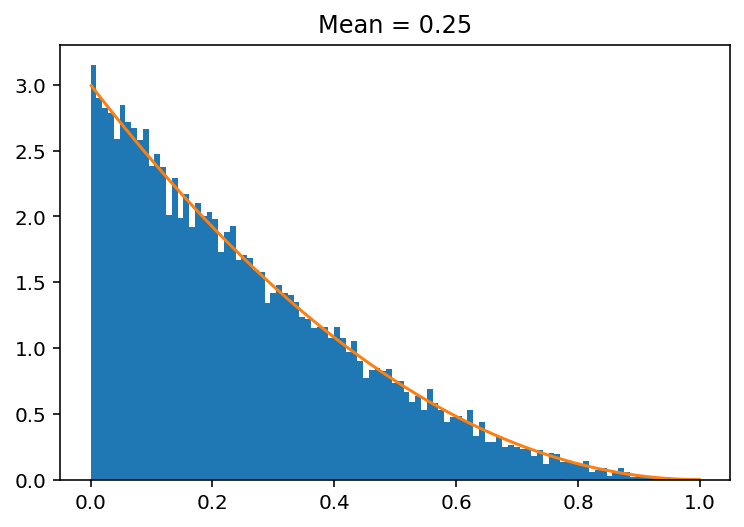

In [7]:
rng = np.random.RandomState(seed=34)
beta_draws = stick_glueing(stickbreakingweights(alpha=M, size=[1000, K]).eval()).reshape(-1,)

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = plt.hist(beta_draws, bins=100, density=True)
_ = plt.plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M)
)
_ = plt.title(f"Mean = {np.around(beta_draws.mean(), 2)}")

In [57]:
class StickBreakingWeights(Continuous):
    rv_op = stickbreakingweights
    
    def __new__(cls, name, *args, **kwargs):
        kwargs.setdefault("transform", transforms.stick_breaking)
        return super().__new__(cls, name, *args, **kwargs)

    @classmethod
    def dist(cls, alpha, *args, **kwargs):
        alpha = at.as_tensor_variable(floatX(alpha))

        assert_negative_support(alpha, "alpha", "StickBreakingWeights")

        return super().dist([alpha], **kwargs)

    def logp(value, alpha):
        K = floatX(value.shape[-1])
        
        print(value.eval())
        logp = -at.sum(
            at.log(
                at.cumsum(
                    value[..., ::-1],
                    axis=-1,
                )
            ),
            axis=-1,
        )
        print(logp.eval())
        print("")
        logp -= -K * betaln(1, alpha)
        logp += alpha * at.log(value[..., -1])

        return bound(
            logp,
            alpha > 0,
            at.all(value >= 0),
            at.all(value <= 1),
        )

In [73]:
with pm.Model() as model:
    α = pm.Gamma(name="α", alpha=4., beta=2.)
    sbw = StickBreakingWeights(name="sbw", alpha=α, size=[K,])
    prior = pm.sample_prior_predictive(samples=2000,)
    trace = pm.sample(draws=2000, chains=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [81]:
trace.to_dict()["posterior"]

{'α': array([[1.25458286, 1.2270209 , 6.38395492, ..., 0.40911869, 0.47817977,
         0.59507866]])}

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: overflow encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:851: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 513

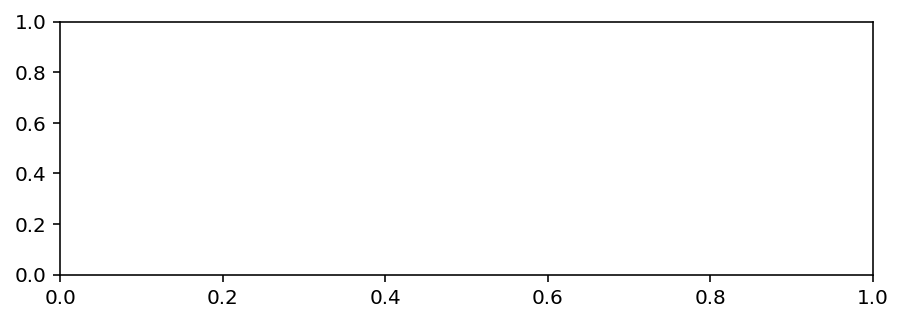

In [68]:
_ = pm.plot_trace(trace)

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


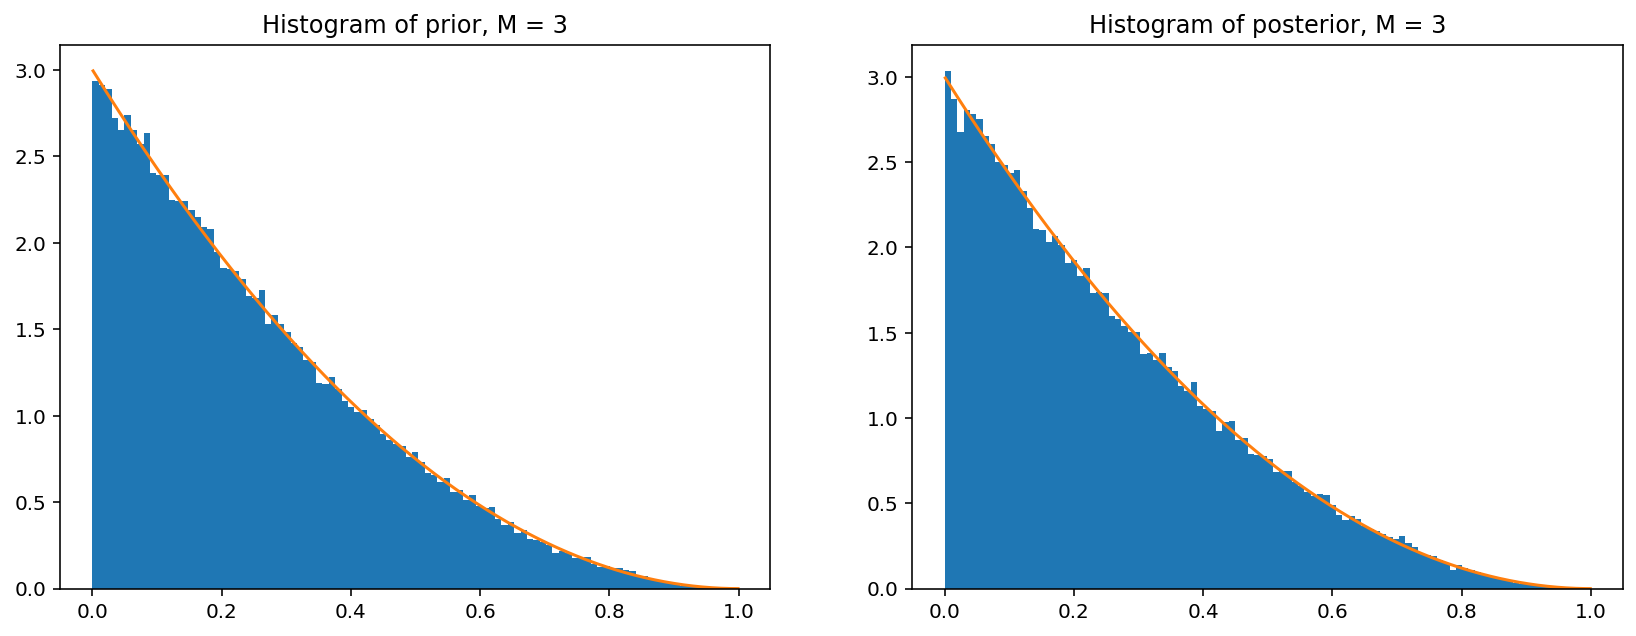

In [11]:
prior_beta_draws = stick_glueing(prior["sbw"]).reshape(-1,)
post_beta_draws = stick_glueing(trace.to_dict()["posterior"]["sbw"][0]).reshape(-1,)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = axes[0].hist(prior_beta_draws, bins=100, density=True)
_ = axes[0].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[0].set_title(f"Histogram of prior, M = {M}", fontsize=12)

_ = axes[1].hist(post_beta_draws, bins=100, density=True)
_ = axes[1].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[1].set_title(f"Histogram of posterior, M = {M}", fontsize=12)

## Testing the equivalence between `pm.sample_prior_predictive` and `pm.sample` without any observations

In [12]:
with pm.Model() as model:
    norm = pm.Normal("norm", mu=2., sigma=2.)
    prior_norm = pm.sample_prior_predictive(samples=10000,)
    trace_norm = pm.sample(draws=10000, chains=1,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [norm]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


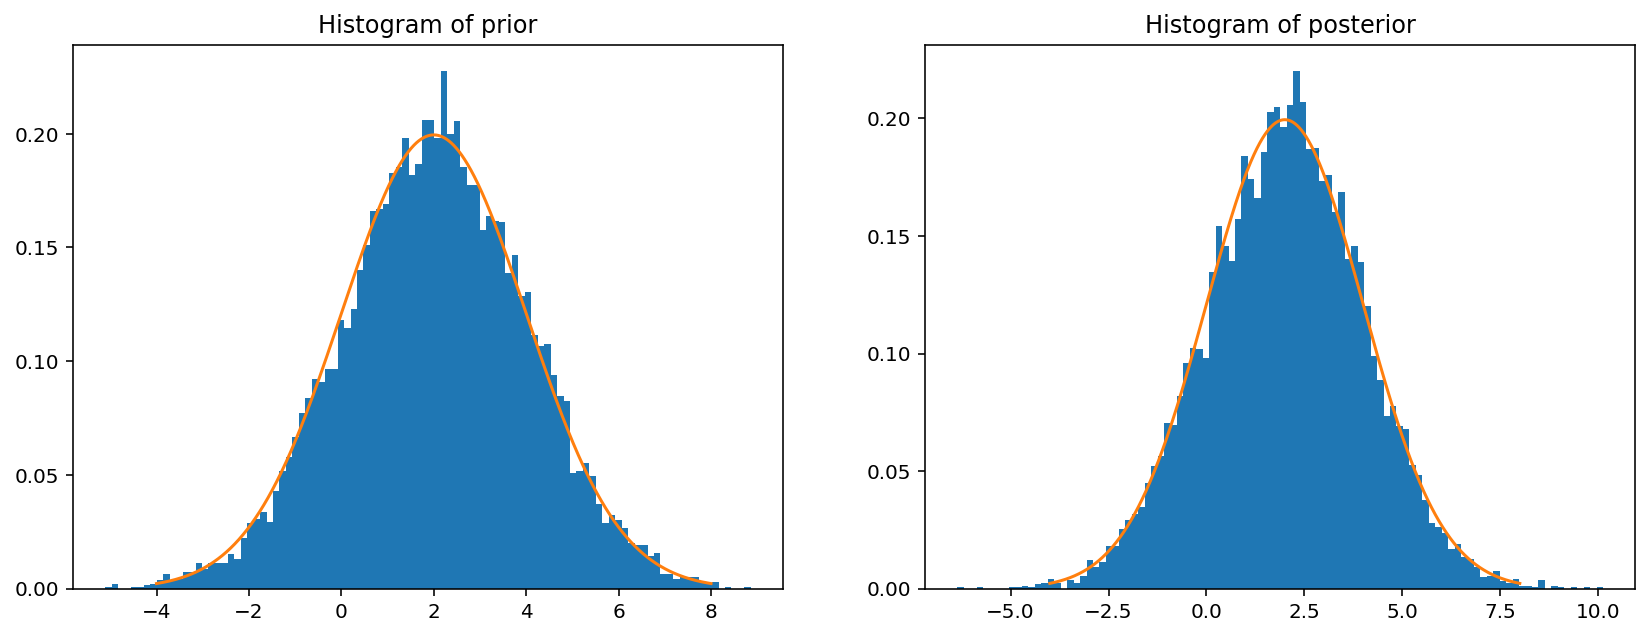

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_norm_plot = np.linspace(-4, 8, num=10001,)

_ = axes[0].hist(prior_norm["norm"], bins=100, density=True)
_ = axes[0].plot(x_norm_plot, st.norm.pdf(x_norm_plot, 2, 2))
_ = axes[0].set_title("Histogram of prior", fontsize=12)

_ = axes[1].hist(trace_norm.to_dict()["posterior"]["norm"][0], bins=100, density=True)
_ = axes[1].plot(
    x_norm_plot,
    st.norm.pdf(x_norm_plot, 2, 2),
)
_ = axes[1].set_title("Histogram of posterior", fontsize=12)

## Testing

In [14]:
from pymc.tests.test_distributions import TestMatchesScipy

test_obj = TestMatchesScipy()